In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import xgboost as xgb
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit



In [2]:
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if str(filename) == 'sample_submission.csv' or str(filename) == 'store.csv':
            if str(filename) == 'store.csv':
                store_data_path = Path(os.path.join(dirname, filename))
            continue
        print(os.path.join(dirname, filename))
        paths.append(Path(os.path.join(dirname, filename)))

/kaggle/input/playground-series-s5e5/train.csv
/kaggle/input/playground-series-s5e5/test.csv


In [3]:
dat = {}
for i in paths:
    with open(i,'r') as f:
        dat[i.stem] = pd.read_csv(f)
dat_org = dat['train']
for i in dat:
    dat[i]['Sex'], _ = pd.factorize(dat[i]['Sex'])
    dat[i]['Belastung'] = dat[i]['Heart_Rate'] * dat[i]['Duration']
    dat[i]['Belastung_2'] = dat[i]['Body_Temp'] * dat[i]['Duration']
    dat[i]['Body_type'] = dat[i]['Height'] * dat[i]['Age'] *  dat[i]['Weight']

In [4]:
dat['test'].head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Belastung,Belastung_2,Body_type
0,750000,0,45,177.0,81.0,7.0,87.0,39.8,609.0,278.6,645165.0
1,750001,0,26,200.0,97.0,20.0,101.0,40.5,2020.0,810.0,504400.0
2,750002,1,29,188.0,85.0,16.0,102.0,40.4,1632.0,646.4,463420.0
3,750003,1,39,172.0,73.0,20.0,107.0,40.6,2140.0,812.0,489684.0
4,750004,1,30,173.0,67.0,16.0,94.0,40.5,1504.0,648.0,347730.0


In [5]:
dat['train'].head(5)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Belastung,Belastung_2,Body_type
0,0,0,36,189.0,82.0,26.0,101.0,41.0,150.0,2626.0,1066.0,557928.0
1,1,1,64,163.0,60.0,8.0,85.0,39.7,34.0,680.0,317.6,625920.0
2,2,1,51,161.0,64.0,7.0,84.0,39.8,29.0,588.0,278.6,525504.0
3,3,0,20,192.0,90.0,25.0,105.0,40.7,140.0,2625.0,1017.5,345600.0
4,4,1,38,166.0,61.0,25.0,102.0,40.6,146.0,2550.0,1015.0,384788.0


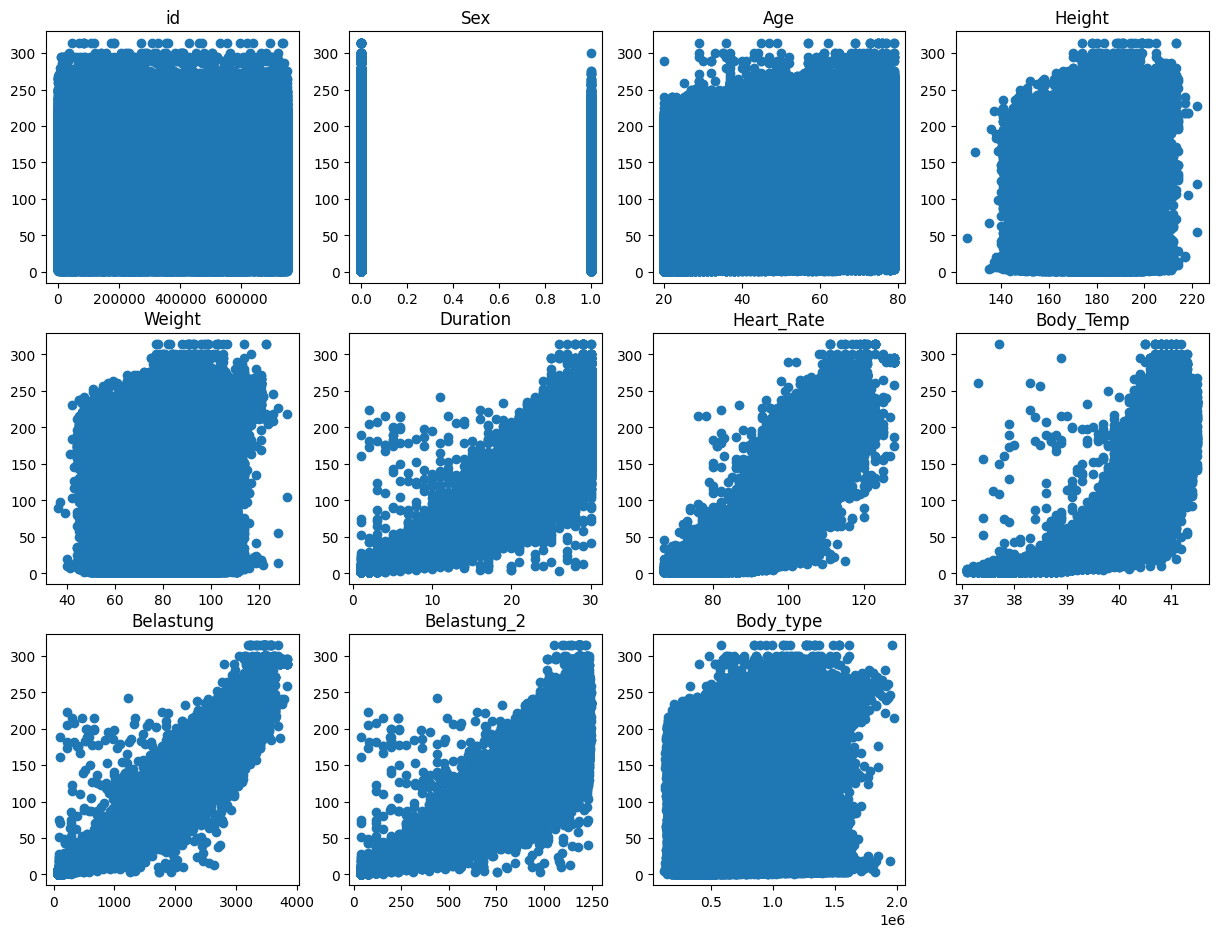

In [6]:
target = dat['train']['Calories']
features = dat['train'].drop(columns=['Calories'])

plt.figure(figsize=(15,15))
for i,x in enumerate(features):
    plt.subplot(4,4,i+1)
    plt.scatter(dat['train'][x],target)
    plt.title(x)
plt.show()

In [7]:
heatmap = dat['train'].corr(method='pearson', min_periods=1, numeric_only=True)['Calories']

heatmap = heatmap.to_frame()

heatmap.style.background_gradient(cmap='coolwarm').format(precision=2)

,Calories
id,0.00
Sex,-0.01
Age,0.15
Height,-0.00
Weight,0.02
Duration,0.96
Heart_Rate,0.91
Body_Temp,0.83
Calories,1.00
Belastung,0.98


In [8]:
heatmap = dat['train'].corr(method='pearson', min_periods=1, numeric_only=False)
heatmap.style.background_gradient(cmap='coolwarm').format(precision=2)

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories,Belastung,Belastung_2,Body_type
id,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sex,0.00,1.00,-0.01,-0.76,-0.82,0.01,-0.01,0.02,-0.01,0.01,0.01,-0.45
Age,0.00,-0.01,1.00,0.01,0.07,0.02,0.02,0.03,0.15,0.02,0.02,0.81
Height,0.00,-0.76,0.01,1.00,0.96,-0.03,-0.01,-0.03,-0.00,-0.03,-0.03,0.55
Weight,0.00,-0.82,0.07,0.96,1.00,-0.02,-0.00,-0.02,0.02,-0.02,-0.02,0.61
Duration,0.00,0.01,0.02,-0.03,-0.02,1.00,0.88,0.90,0.96,0.99,1.00,-0.00
Heart_Rate,0.00,-0.01,0.02,-0.01,-0.00,0.88,1.00,0.80,0.91,0.91,0.88,0.01
Body_Temp,0.00,0.02,0.03,-0.03,-0.02,0.90,0.80,1.00,0.83,0.88,0.90,0.01
Calories,0.00,-0.01,0.15,-0.00,0.02,0.96,0.91,0.83,1.00,0.98,0.96,0.13
Belastung,0.00,0.01,0.02,-0.03,-0.02,0.99,0.91,0.88,0.98,1.00,0.99,0.00


In [9]:
X = dat['train'].drop(["Calories"], axis=1)
y = dat['train']['Calories']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

model = xgb.XGBRegressor()

tscv = TimeSeriesSplit(n_splits=5)

In [11]:
search = xgb.XGBRegressor(
    device='cuda',
    subsample=1.0,
    reg_lambda=2,
    reg_alpha=1,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.05,
    gamma=0,
    colsample_bytree=0.8
)

In [12]:
search.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
y_pred = search.predict(X_val)

y_pred = np.maximum(0, y_pred)
y_test = np.maximum(0, y_val)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [10:59:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.060248955909644755 ,


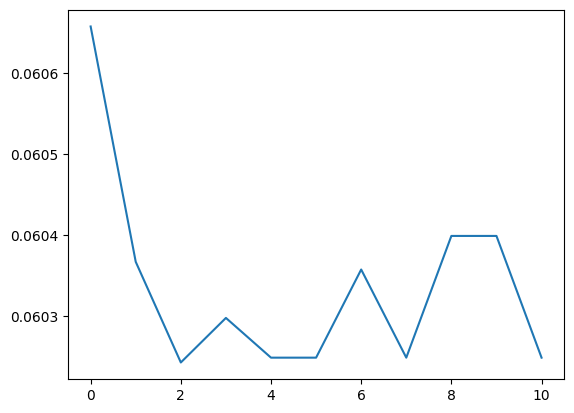

In [14]:
rmsle_value = np.sqrt(mean_squared_log_error(y_test, y_pred))
print(rmsle_value,',')

res = [0.06065696859686999,
       0.060367018170745426,
       0.06024301895486139,
       0.06029790983393293,
       0.060248955909644755, 
       0.060248955909644755,
       0.06035755224101099,
       0.060248955909644755,
       0.060398920637448436,
       0.060398920637448436,
       0.060248955909644755,
      ]
plt.plot(res)
plt.show()

In [15]:
# X_test = dat['test']

# submission = pd.DataFrame()

# submission['id'] = X_test['id']

# submission['Calories'] = search.predict(X_test)

# submission.to_csv("submission.csv", index=False)